In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns  #Unused import
import os
#from symspellpy import SymSpell, Verbosity
import pkg_resources

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Conv2D, MaxPool2D, 
                                     BatchNormalization, Flatten, GlobalAveragePooling2D, Input,
                                     LSTM, Bidirectional, TimeDistributed, Reshape, Embedding)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB7, MobileNetV2, VGG19, DenseNet121

from tensorflow.keras.regularizers import l2

In [3]:
def directory_to_df(path : str):
    """
    This function to retrieve all images from targeted folder in a file, the
    folder must be divided hirarchally in which each class contains its images individually.
    ________________________________________________________________________________________________
    Arguments-
    
    path: String -> the main folder directory that contains train/test folders
    
    ________________________________________________________________________________________________
    Return-
    
    DataFrame: contains the images path and label corresponding to every image
    """
    df = []
    chars = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789!,#&()-$%;@[]^_`}{~+'
    for cls in os.listdir(path):
        cls_path = os.path.join(path,cls)
        cls_name = cls.split('_')[0]
        if not cls_name in chars:
            if cls_name == 'qmark':
                cls_name = '?'
            elif cls_name == 'dot':
                cls_name = '.'
            elif cls_name == 'colon':
                cls_name = ':'
            else:
                continue
        for img_path in os.listdir(cls_path):
            direct = os.path.join(cls_path,img_path)
            df.append([direct,cls_name])
    
    df = pd.DataFrame(df, columns=['image','label'])
    print("The number of samples found:",len(df))
    return df.copy()

def read_image(path):
    """
    Read an image from specified directory
    _____________________________________________________________
    Arguments:
    
    path: String -> a directory of the image
    _____________________________________________________________
    Return:
    
    image: numpy.array of the image
    """
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def show_image(img, label=None) -> None:
    """
    This function to display any image
    _________________________________________________________
    Arguements:
    
    img: numpy.array of N-D
    
    label: String -> the title/label added with the image, Default= None
    _________________________________________________________
    Return:
    
    plt.imshow()
    """
    plt.imshow(img, cmap='gray')
    plt.axis(False)
    plt.title(label)
    plt.show()
    
def clbck(model_name):
    # The function is defined to make the callbacks for training the models
    ERLY = EarlyStopping(patience=10, min_delta=0.01, start_from_epoch=10, verbose=1)
    RD = ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=3,
        verbose=1, 
        min_lr=1e-6, 
    )
    CHK = ModelCheckpoint(f'models/{model_name}_model.keras',verbose=1, save_best_only=True)
    return [ERLY,RD,CHK]

In [4]:
# Pre-defined hyperparameters
IMG_SHAPE = (64, 64)
IMG_SIZE = (64, 64, 3)
BATCH_SIZE = 32
opt = Adam(learning_rate=0.0001, epsilon=1e-6)
loss = 'categorical_crossentropy'
EPOCHS = 50

# Model selection
# 1. EfficientNetB7
# 2. CustomCNN
# MODEL_SEL = 'EfficientNetB7'
MODEL_SEL = 'CustomCNN'

I0000 00:00:1732887647.192738    3665 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4080 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


## 3) Reading & preparing the dataset

In [5]:
# Reading the dataset in dataframe 
main_path = 'data/raw/character_set3/'
df = directory_to_df(main_path)                   # convert the dataset into df of two columns
df.head()

The number of samples found: 201956


,image,label
0,data/raw/character_set3/y/Y_L_1099.png,y
1,data/raw/character_set3/y/Y_L_2132.png,y
2,data/raw/character_set3/y/Y_L_791.png,y
3,data/raw/character_set3/y/Y_L_1007.png,y
4,data/raw/character_set3/y/Y_L_493.png,y


In [6]:
df['label'].value_counts()

label
I    4046
K    4046
M    4046
R    4046
P    4046
     ... 
;     194
.     188
%     184
$     174
-     173
Name: count, Length: 85, dtype: int64

3.1) Splitting the dataframe

In [7]:
# Splitting for training & testing (70,30 respectively)
X, y = df['image'], df['label']
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.30, random_state=41)
training_df = pd.concat((X_train,y_train), axis=1)
testing_df = pd.concat((X_test,y_test), axis=1)

In [8]:
# Splitting for training & validation (75,25 respectively) -> the training set size = 52.5%
X, y = training_df['image'], training_df['label']
X_train, X_valid, y_train, y_valid = train_test_split(X,y , test_size=0.25, random_state=41)
training_df = pd.concat((X_train,y_train), axis=1)
validation_df = pd.concat((X_valid,y_valid), axis=1)

3.2) Creating generators

In [9]:
# Creating generators
gen = ImageDataGenerator(
    rotation_range=1,
    shear_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest',
    dtype=np.int32,
)

gen2 = ImageDataGenerator(dtype=np.int32, fill_mode='nearest')
train_gen = gen.flow_from_dataframe(training_df, x_col='image',y_col='label', batch_size=BATCH_SIZE, 
                                   target_size=IMG_SHAPE)
valid_gen = gen2.flow_from_dataframe(validation_df, x_col='image', y_col='label', batch_size=BATCH_SIZE, 
                                        target_size=IMG_SHAPE, shuffle=False)
test_gen = gen2.flow_from_dataframe(testing_df, x_col='image', y_col='label', batch_size=BATCH_SIZE, 
                                       target_size=IMG_SHAPE, shuffle=False)

Found 106026 validated image filenames belonging to 85 classes.
Found 35343 validated image filenames belonging to 85 classes.
Found 60587 validated image filenames belonging to 85 classes.


In [10]:
# Making a mapping of the classes and the inverse for later processings
mapping = train_gen.class_indices
mapping_inverse = dict(map(lambda x: tuple(reversed(x)), mapping.items()))

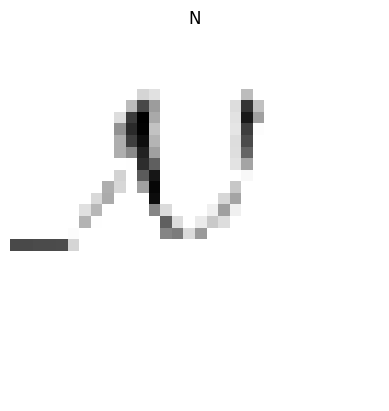

The shape of the image: (32, 32, 3)


In [11]:
# Reading a sample from the dataset
BATCH_NUM = 10
IMG_NUM = 2      # from 0 to 31
show_image(train_gen[BATCH_NUM][0][IMG_NUM],mapping_inverse[train_gen[BATCH_NUM][1][IMG_NUM].argmax()])
print('The shape of the image:',train_gen[BATCH_NUM][0][IMG_NUM].shape)

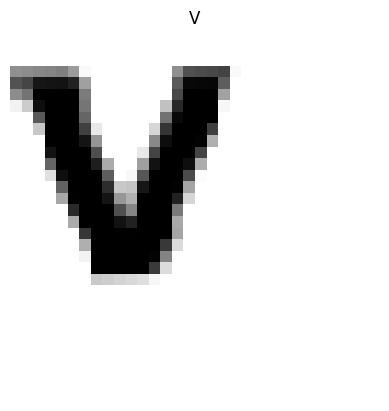

The shape of the image: (32, 32, 3)


In [12]:
# Reading another sample from the dataset
BATCH_NUM = 65
IMG_NUM = 30      # from 0 to 31
show_image(train_gen[BATCH_NUM][0][IMG_NUM],mapping_inverse[train_gen[BATCH_NUM][1][IMG_NUM].argmax()])
print('The shape of the image:',train_gen[BATCH_NUM][0][IMG_NUM].shape)

In [ ]:
BATCH_NUM = 0
IMG_NUM = 0      # from 0 to 31
for i in range(32):
    show_image(train_gen[BATCH_NUM][0][IMG_NUM+i],mapping_inverse[train_gen[BATCH_NUM][1][IMG_NUM+i].argmax()])
    print('The shape of the image:',train_gen[BATCH_NUM][0][IMG_NUM+i].shape)

# 4) Modeling

## 4.1) Custom Model

In [13]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2

CNN_model = Sequential()
CNN_model.add(Input(shape=IMG_SIZE, name='Input'))
CNN_model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
CNN_model.add(BatchNormalization())
CNN_model.add(Conv2D(32, (3,3), activation='relu'))
CNN_model.add(BatchNormalization())
CNN_model.add(MaxPool2D((2,2)))
CNN_model.add(Dropout(0.25))

CNN_model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
CNN_model.add(BatchNormalization())
CNN_model.add(Conv2D(64, (3,3), activation='relu'))
CNN_model.add(BatchNormalization())
CNN_model.add(MaxPool2D((2,2)))
CNN_model.add(Dropout(0.25))

CNN_model.add(Conv2D(128, (3,3), activation='relu', padding='same'))  # Added layer
CNN_model.add(BatchNormalization())
CNN_model.add(MaxPool2D((2,2)))
CNN_model.add(Dropout(0.25))

CNN_model.add(Flatten())
CNN_model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))  # Increased units
CNN_model.add(Dropout(0.5))
CNN_model.add(Dense(len(mapping), activation='softmax'))

In [14]:
CNN_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 30, 30, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 6, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 85)             │        21,84

 Total params: 441,973 (1.69 MB)

 Trainable params: 441,077 (1.68 MB)

 Non-trainable params: 896 (3.50 KB)

In [15]:
# Default parameters of adam will be used for the custom CNN
CNN_model.compile(optimizer=Adam(), loss=loss, metrics=['accuracy'])

## 4.2) Callback Name Setup
This will allow you to call the model without having to re-train the model everytime. Simply change the `callback_name` to save a new model in the 'models' folder.

In [16]:
# Change the name of the model at this variable.
callback_name = 'CustomCNN'

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    verbose=1, 
    min_lr=1e-6, 
    )

callback = clbck(callback_name) + [reduce_lr] 

## 4.3) Start Training

In [17]:
# different num. of epochs will be given for better convergence for the Custom CNN
history = CNN_model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=valid_gen,
    callbacks=clbck(MODEL_SEL),
)

/home/kenji/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1732887800.585607   48387 service.cc:148] XLA service 0x7f21fc003c00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732887800.586889   48387 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-11-29 21:43:20.984370: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732887801.954163   48387 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-29 21:43:24.018164: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,32,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,32,32]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_co

   2/3314 ━━━━━━━━━━━━━━━━━━━━ 3:23 62ms/step - accuracy: 0.0078 - loss: 6.8390       

I0000 00:00:1732887815.451739   48387 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 994/3314 ━━━━━━━━━━━━━━━━━━━━ 4:00 104ms/step - accuracy: 0.1447 - loss: 4.0084

2024-11-29 21:45:20.549913: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[10,32,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[10,3,32,32]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-11-29 21:45:20.694938: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[10,32,30,30]{3,2,1,0}, u8[0]{0}) custom-call(f32[10,32,32,32]{3,2,1,0}, f32[32,32,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", bac

3314/3314 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.3699 - loss: 2.8322

2024-11-29 21:50:02.600263: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,32,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,32,32]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-11-29 21:50:02.732655: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,32,30,30]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,32,32]{3,2,1,0}, f32[32,32,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", bac


Epoch 1: val_loss improved from inf to 1.01832, saving model to models/CustomCNN_model.keras
3314/3314 ━━━━━━━━━━━━━━━━━━━━ 465s 134ms/step - accuracy: 0.3699 - loss: 2.8319 - val_accuracy: 0.7707 - val_loss: 1.0183 - learning_rate: 0.0010
Epoch 2/50
3314/3314 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7657 - loss: 1.0237
Epoch 2: val_loss improved from 1.01832 to 0.61461, saving model to models/CustomCNN_model.keras
3314/3314 ━━━━━━━━━━━━━━━━━━━━ 171s 52ms/step - accuracy: 0.7657 - loss: 1.0237 - val_accuracy: 0.8642 - val_loss: 0.6146 - learning_rate: 0.0010
Epoch 3/50
3314/3314 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8029 - loss: 0.8566
Epoch 3: val_loss did not improve from 0.61461
3314/3314 ━━━━━━━━━━━━━━━━━━━━ 193s 58ms/step - accuracy: 0.8029 - loss: 0.8566 - val_accuracy: 0.7125 - val_loss: 1.2266 - learning_rate: 0.0010
Epoch 4/50
3314/3314 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8164 - loss: 0.7906
Epoch 4: val_loss did not improve from 0.61461
3314/3314

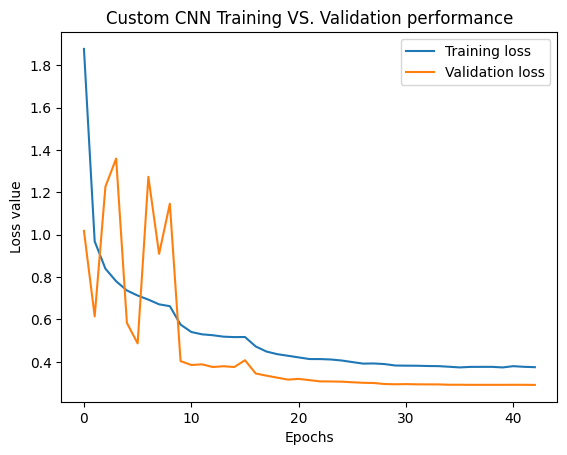

In [18]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("Custom CNN Training VS. Validation performance")
plt.show()

In [19]:
# Making a prediction out of the Custom CNN for the testing set for the evaluation
prediction = CNN_model.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

1893/1894 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

2024-11-29 23:25:51.616583: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[11,32,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[11,3,32,32]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-11-29 23:25:51.662658: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[11,32,30,30]{3,2,1,0}, u8[0]{0}) custom-call(f32[11,32,32,32]{3,2,1,0}, f32[32,32,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", bac

1894/1894 ━━━━━━━━━━━━━━━━━━━━ 48s 25ms/step


In [20]:
print('\t\tThe Custom CNN Evaluation Performance')
print(classification_report(y_test, pred))

		The Custom CNN Evaluation Performance
              precision    recall  f1-score   support

                   0.92      1.00      0.96       110
           !       1.00      1.00      1.00        78
           #       1.00      1.00      1.00        97
           $       1.00      1.00      1.00        55
           %       1.00      1.00      1.00        67
           &       1.00      1.00      1.00        61
           (       1.00      1.00      1.00        78
           )       1.00      1.00      1.00        74
           +       1.00      1.00      1.00        73
           ,       1.00      1.00      1.00        56
           -       1.00      0.80      0.89        49
           .       1.00      1.00      1.00        51
           0       0.58      0.94      0.72       160
           1       0.98      0.98      0.98       189
           2       0.98      0.99      0.99       165
           3       0.99      1.00      1.00       181
           4       0.99      0.99      0.

# 6) Post-Processing

In [21]:
# Computer Vision - Low level techniques
def load_model():
    model_path = f'models/{MODEL_SEL}_model.keras'
    model = tf.keras.models.load_model(model_path)
    return model

def convert_2_gray(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return gray_image

def binarization(image):
    img, thresh = cv2.threshold(image, 0,255, cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)
    return img, thresh

def dilate(image, words= False):
    img = image.copy()
    m = 3
    n = m - 2                   # n less than m for Vertical structuring element to dilate chars
    itrs = 4
    if words:
        m = 6
        n = m
        itrs = 3
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (n, m))
    dilation = cv2.dilate(img, rect_kernel, iterations = itrs)
    return dilation

def find_rect(image):
    '''
    find the text region in the image and return the coordinates of the rectangles in a sorted manner.
    
    Input: image -> numpy.array of the image
    
    Output: list of rectangles coordinates sorted from top-to-bottom, left-to-right.
    '''
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    rects = []
    
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        rects.append([x, y, w, h])
    
    if not rects:
        return []
    
    # Calculate average height
    avg_height = np.mean([r[3] for r in rects])
    margin = avg_height / 2
    
    # Sort rectangles by y-coordinate
    rects_sorted = sorted(rects, key=lambda r: r[1])
    
    lines = []
    current_line = []
    current_y = rects_sorted[0][1]
    
    for rect in rects_sorted:
        x, y, w, h = rect
        if abs(y - current_y) <= margin:
            current_line.append(rect)
        else:
            # Sort the current line by x-coordinate
            current_line = sorted(current_line, key=lambda r: r[0])
            lines.append(current_line)
            current_line = [rect]
            current_y = y
    # Add the last line
    if current_line:
        current_line = sorted(current_line, key=lambda r: r[0])
        lines.append(current_line)
    
    # Flatten the list of lines
    sorted_rects = [rect for line in lines for rect in line]
    
    return sorted_rects

def extract(image):
    model = load_model()
    chars = []              # a list to store recognized characters
    
    image_cpy = image.copy()
    _, bin_img = binarization(convert_2_gray(image_cpy))
    full_dil_img = dilate(bin_img,words=True)
    words = find_rect(full_dil_img)                       # Recognized words within the image 
    del _, bin_img, full_dil_img                          # for better memory usage
    
    for word in words:
        x,y,w,h = word                                    # coordinates of the word
        img = image_cpy[y:y+h, x:x+w]
        
        _, bin_img = binarization(convert_2_gray(img))
        dil_img = dilate(bin_img)
        char_parts = find_rect(dil_img)                     # Recognized chars withtin the word
        cv2.rectangle(image, (x,y),(x+w,y+h), (0,255,0), 3) # draw a green rectangle around the word
        
        del _, bin_img, dil_img
        
        for char in char_parts:    
            x,y,w,h = char
            ch = img[y:y+h, x:x+w]
            
            empty_img = np.full((64,64,1),255, dtype=np.uint8) # a white image used for resize with filling
            x,y = 3,3                                          # starting indecies
            resized = cv2.resize(ch, (32,44), interpolation=cv2.INTER_CUBIC)
            gray = convert_2_gray(resized)
            empty_img[y:y+44, x:x+32,0] = gray.copy()          # integrate the recognized char into the white image
            gray = cv2.cvtColor(empty_img, cv2.COLOR_GRAY2RGB)
            gray = gray.astype(np.int32)
            
            predicted = mapping_inverse[np.argmax(model.predict(np.array([gray]), verbose=-1))]
            chars.append(predicted)                            # append the character into the list
            
            del ch, resized, gray, empty_img
        chars.append(' ')  # at the end of each iteration (end of word) append a space
        
    del model
    show_image(image)
    return ''.join(chars[:-1])

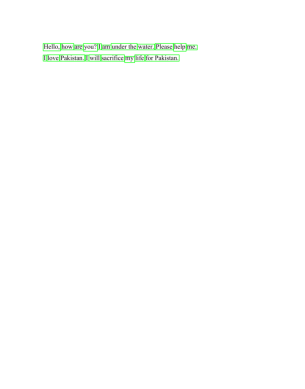

--> HellOD hOW are yOuQ I am underthe Water. PleaSe help me. I lOVe PXiStM. I Will SaCrifCe my life fOrPXiStan.


In [75]:
# Testing 1 (Upper case + Lower case)
img = read_image('data/test/Test_7.png')
text = extract(img)
print('-->',text)

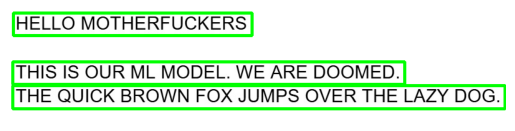

--> HELLOMOTHERFUCKERS THISISOURMLMODELWEAREDOOMED.. THEQUICKBROWNFOXJUMPSOVERTHELAZYDOG.


In [77]:
# Testing 2 (Lower case)
img = read_image('data/test/Test_3.png')
text = extract(img)
print('-->',text)

## Spell checking with SymSpell

Symspell performs a spell checking on the OCR'ed text and correct text based on its dictionary database.

In [ ]:
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

input_term = text
result = sym_spell.word_segmentation(input_term)
print('The corrected text:',result.corrected_string)